# Input Data and Variables

In [1]:
import numpy as np
import os
import pandas as pd
import arcpy

# Import the required ArcGIS API for Python modules
import arcgis
from arcgis.gis import GIS
gis = arcgis.GIS()
from arcgis.geoanalytics import manage_data

from IPython.display import display, Markdown

In [2]:
dirWork         = os.getcwd()
dirInput        = os.path.join(dirWork, r'input'       )
dirIntermediate = os.path.join(dirWork, r'intermediate')
dirResults      = os.path.join(dirWork, r'results'     )
dirParams       = os.path.join(dirWork, r'params'      )

#read parameter tables
prmExclusions    = pd.read_csv(os.path.join(dirParams, r'exclusions.csv' ), parse_dates=['DATEFROM','DATETO'])
prmHolidays      = pd.read_csv(os.path.join(dirParams, r'holidays.csv'   ))
prmGeographies   = pd.read_csv(os.path.join(dirParams, r'geographies.csv'))
prmStationGroups = pd.read_csv(os.path.join(dirParams, r'station_groups.csv'))

prmHolidays['DATE'] = pd.to_datetime(prmHolidays[['YEAR', 'MONTH', 'DAY']])



# Read in CCS Hour/Dir Volume Data

In [3]:
#import to csv
df_CCSHourDir = pd.read_csv(os.path.join(dirIntermediate, r'CCSHourDir_Combined_2013to2019.csv'))

In [4]:
#calculate date
df_CCSHourDir['DATE'] = pd.to_datetime(df_CCSHourDir[['YEAR', 'MONTH', 'DAY']])

#create index column for easy exlusion/holday
df_CCSHourDir = df_CCSHourDir.reset_index()
df_CCSHourDir

,index,STATION,YEAR,MONTH,DAY,DOW,HOUR,DIR,HOURVOL,DATE
0,0,301,2013,1,1,1,0,N,358,2013-01-01
1,1,301,2013,1,1,1,0,P,288,2013-01-01
2,2,301,2013,1,1,1,1,N,435,2013-01-01
3,3,301,2013,1,1,1,1,P,292,2013-01-01
4,4,301,2013,1,1,1,2,N,277,2013-01-01
...,...,...,...,...,...,...,...,...,...,...
9379250,9379250,716,2019,6,29,5,0,P,7494,2019-06-29
9379251,9379251,716,2019,6,30,6,0,N,5032,2019-06-30
9379252,9379252,716,2019,6,30,6,0,P,4707,2019-06-30
9379253,9379253,716,2019,7,29,0,0,N,7037,2019-07-29


# Flag Rows that are Excluded from Analysis (exlusions and holidays)

## Mark Excluded Data

In [5]:
#exclusions
df_CCSHourDir['EXCLUDE'] = 0

df_CCSHourDirExclude = pd.DataFrame.merge(df_CCSHourDir,prmExclusions,on='STATION')
df_CCSHourDirExclude = df_CCSHourDirExclude[(df_CCSHourDirExclude['DATE']>=df_CCSHourDirExclude['DATEFROM']) & (df_CCSHourDirExclude['DATE']<=df_CCSHourDirExclude['DATETO'])]
lstExclude = df_CCSHourDirExclude['index'].to_list()

df_CCSHourDir.loc[df_CCSHourDir.index.isin(lstExclude), 'EXCLUDE'] = 1

#check number of records
df_CCSHourDir['EXCLUDE'].sum()

45120

## Mark Holiday Data

In [6]:
#holidays
df_CCSHourDir['HOLIDAY'] = 0

df_CCSHourDirHoliday = pd.DataFrame.merge(df_CCSHourDir,prmHolidays,on='DATE')
lstHoliday = df_CCSHourDirHoliday['index'].to_list()

df_CCSHourDir.loc[df_CCSHourDir.index.isin(lstHoliday), 'HOLIDAY'] = 1

#check number of records
df_CCSHourDir['HOLIDAY'].sum()

317882

# Calculate Daily Volumes

In [7]:
df_CCSHourDir_ExclusionsRemoved = df_CCSHourDir.loc[(df_CCSHourDir['EXCLUDE']==0) & (df_CCSHourDir['HOLIDAY']==0)]

df_CCSDay = df_CCSHourDir_ExclusionsRemoved.groupby(['STATION','YEAR','MONTH','DAY','DOW','DATE'],as_index=False).agg({'HOURVOL':[np.sum],'index':[np.size]})
df_CCSDay.columns = df_CCSDay.columns.droplevel(1)
df_CCSDay = df_CCSDay.rename(columns={'HOURVOL':'DAYVOL','index':'NUMREC'})
df_CCSDay

,STATION,YEAR,MONTH,DAY,DOW,DATE,DAYVOL,NUMREC
0,301,2013,1,2,2,2013-01-02,48604,48
1,301,2013,1,3,3,2013-01-03,48287,48
2,301,2013,1,4,4,2013-01-04,51901,48
3,301,2013,1,5,5,2013-01-05,47536,48
4,301,2013,1,6,6,2013-01-06,36662,48
...,...,...,...,...,...,...,...,...
257753,716,2019,6,27,3,2019-06-27,17194,2
257754,716,2019,6,28,4,2019-06-28,17602,2
257755,716,2019,6,29,5,2019-06-29,15212,2
257756,716,2019,6,30,6,2019-06-30,9739,2


# Calculate Month ADT

In [8]:
#average over month for each weekday
df_CCSMonthDOW = df_CCSDay.groupby(['STATION','YEAR','MONTH','DOW'],as_index=False).agg({'DAYVOL':[np.mean],'DATE':[np.size]})
df_CCSMonthDOW.columns = df_CCSMonthDOW.columns.droplevel(1)
df_CCSMonthDOW = df_CCSMonthDOW.rename(columns={'DAYVOL':'MONTHDOWADT','DATE':'NUMREC'})
#df_CCSMonthDOW['DOWVOL'] = df_CCSMonthDOW['DOWVOL'].astype(int)
df_CCSMonthDOW

,STATION,YEAR,MONTH,DOW,MONTHDOWADT,NUMREC
0,301,2013,1,0,41221.333333,3
1,301,2013,1,1,44297.000000,4
2,301,2013,1,2,47701.400000,5
3,301,2013,1,3,47551.400000,5
4,301,2013,1,4,47747.750000,4
...,...,...,...,...,...,...
63624,716,2019,6,3,17577.750000,4
63625,716,2019,6,4,18105.250000,4
63626,716,2019,6,5,15521.600000,5
63627,716,2019,6,6,9873.600000,5


In [9]:
#average month dow
df_CCSMonthADT = df_CCSMonthDOW.groupby(['STATION','YEAR','MONTH'],as_index=False).agg({'MONTHDOWADT':[np.mean],'DOW':[np.size]})
df_CCSMonthADT.columns = df_CCSMonthADT.columns.droplevel(1)
df_CCSMonthADT = df_CCSMonthADT.rename(columns={'MONTHDOWADT':'MONTHADT','DOW':'NUMDOW'})
#df_CCSMonthADT['MONTHADT'] = df_CCSMonthADT['MONTHADT'].astype(int)

#only keep months with all 7 DOWs
df_CCSMonthADT = df_CCSMonthADT[df_CCSMonthADT['NUMDOW']==7]
df_CCSMonthADT

,STATION,YEAR,MONTH,MONTHADT,NUMDOW
0,301,2013,1,44843.840476,7
1,301,2013,2,45251.178571,7
2,301,2013,3,46548.835714,7
3,301,2013,4,42423.921429,7
4,301,2013,5,43828.209524,7
...,...,...,...,...,...
9106,716,2019,2,15619.309524,7
9107,716,2019,3,16385.250000,7
9108,716,2019,4,17187.342857,7
9109,716,2019,5,16708.207143,7


# Calculate Annual ADT

In [10]:
#average month dow
df_CCSYearADT = df_CCSMonthADT.groupby(['STATION','YEAR'],as_index=False).agg({'MONTHADT':[np.mean],'MONTH':[np.size]})
df_CCSYearADT.columns = df_CCSYearADT.columns.droplevel(1)
df_CCSYearADT = df_CCSYearADT.rename(columns={'MONTHADT':'YEARADT','MONTH':'NUMMONTH'})
#df_CCSYearADT['YEARADT'] = df_CCSYearADT['YEARADT'].astype(int)
display(df_CCSYearADT)

display(df_CCSYearADT['STATION'].unique())

#only keep years with all 12 months
df_CCSYearADT = df_CCSYearADT[df_CCSYearADT['NUMMONTH']==12]
display(df_CCSYearADT)

display(df_CCSYearADT['STATION'].unique())

,STATION,YEAR,YEARADT,NUMMONTH
0,301,2013,49525.395238,12
1,301,2014,51804.412302,12
2,301,2015,54572.420833,12
3,301,2016,59236.130952,12
4,301,2017,58353.828968,12
...,...,...,...,...
793,714,2017,2309.988492,12
794,714,2018,2875.635516,12
795,714,2019,3109.337897,12
796,715,2019,6424.646429,6


array([301, 302, 303, 304, 305, 306, 307, 308, 309, 310, 312, 313, 314,
       315, 316, 317, 318, 319, 320, 321, 322, 323, 324, 325, 327, 329,
       332, 333, 335, 340, 341, 348, 349, 350, 351, 353, 354, 355, 362,
       363, 382, 400, 401, 402, 403, 404, 405, 406, 407, 408, 409, 411,
       412, 414, 415, 416, 418, 420, 421, 424, 425, 427, 430, 431, 501,
       502, 503, 504, 506, 507, 508, 509, 510, 511, 512, 513, 601, 602,
       605, 606, 609, 611, 612, 613, 614, 615, 616, 617, 619, 620, 621,
       622, 623, 624, 625, 626, 627, 628, 629, 630, 631, 632, 633, 634,
       635, 636, 637, 638, 639, 641, 642, 643, 644, 645, 646, 647, 648,
       649, 650, 651, 653, 654, 655, 656, 657, 658, 659, 660, 661, 662,
       663, 665, 667, 669, 670, 671, 672, 674, 702, 703, 704, 711, 712,
       713, 714, 715, 716], dtype=int64)

,STATION,YEAR,YEARADT,NUMMONTH
0,301,2013,49525.395238,12
1,301,2014,51804.412302,12
2,301,2015,54572.420833,12
3,301,2016,59236.130952,12
4,301,2017,58353.828968,12
...,...,...,...,...
791,714,2015,1233.709524,12
792,714,2016,1750.086706,12
793,714,2017,2309.988492,12
794,714,2018,2875.635516,12


array([301, 302, 303, 304, 305, 306, 307, 308, 309, 310, 312, 313, 314,
       315, 316, 317, 318, 319, 320, 321, 322, 323, 324, 325, 327, 329,
       332, 333, 335, 340, 341, 348, 349, 350, 351, 353, 354, 355, 362,
       363, 382, 400, 401, 402, 403, 404, 405, 406, 407, 408, 409, 411,
       412, 414, 415, 416, 418, 420, 421, 424, 425, 427, 430, 431, 501,
       502, 503, 504, 506, 507, 508, 509, 510, 511, 512, 513, 601, 602,
       605, 606, 609, 611, 612, 613, 614, 615, 616, 617, 619, 620, 621,
       622, 623, 624, 625, 626, 627, 628, 629, 630, 631, 632, 633, 634,
       635, 636, 703, 704, 711, 712, 713, 714], dtype=int64)

# Remove Data From Years that don't have atleast 12 months with 7 days of data

In [11]:
df_CCSDay_incompleteyearsremoved = pd.merge(df_CCSDay, df_CCSYearADT[['STATION','YEAR']], on=['STATION','YEAR'])
df_CCSDay_incompleteyearsremoved = df_CCSDay_incompleteyearsremoved.drop(columns=['NUMREC'])
df_CCSDay_incompleteyearsremoved

,STATION,YEAR,MONTH,DAY,DOW,DATE,DAYVOL
0,301,2013,1,2,2,2013-01-02,48604
1,301,2013,1,3,3,2013-01-03,48287
2,301,2013,1,4,4,2013-01-04,51901
3,301,2013,1,5,5,2013-01-05,47536
4,301,2013,1,6,6,2013-01-06,36662
...,...,...,...,...,...,...,...
238532,714,2019,12,27,4,2019-12-27,3242
238533,714,2019,12,28,5,2019-12-28,2670
238534,714,2019,12,29,6,2019-12-29,2451
238535,714,2019,12,30,0,2019-12-30,3669


In [12]:
df_CCSMonthADT_incompleteyearsremoved = pd.merge(df_CCSMonthADT, df_CCSYearADT[['STATION','YEAR']], on=['STATION','YEAR'])
df_CCSMonthADT_incompleteyearsremoved = df_CCSMonthADT_incompleteyearsremoved.drop(columns=['NUMDOW'])
df_CCSMonthADT_incompleteyearsremoved

,STATION,YEAR,MONTH,MONTHADT
0,301,2013,1,44843.840476
1,301,2013,2,45251.178571
2,301,2013,3,46548.835714
3,301,2013,4,42423.921429
4,301,2013,5,43828.209524
...,...,...,...,...
8347,714,2019,8,2423.964286
8348,714,2019,9,2676.928571
8349,714,2019,10,3647.142857
8350,714,2019,11,3555.816667


In [13]:

df_CCSMonthDOWADT_incompleteyearsremoved = pd.merge(df_CCSMonthDOW, df_CCSYearADT[['STATION','YEAR']], on=['STATION','YEAR'])
df_CCSMonthDOWADT_incompleteyearsremoved = df_CCSMonthDOWADT_incompleteyearsremoved.drop(columns=['NUMREC'])
df_CCSMonthDOWADT_incompleteyearsremoved

,STATION,YEAR,MONTH,DOW,MONTHDOWADT
0,301,2013,1,0,41221.333333
1,301,2013,1,1,44297.000000
2,301,2013,1,2,47701.400000
3,301,2013,1,3,47551.400000
4,301,2013,1,4,47747.750000
...,...,...,...,...,...
58459,714,2019,12,2,3636.666667
58460,714,2019,12,3,3517.750000
58461,714,2019,12,4,3612.000000
58462,714,2019,12,5,2618.750000


# Export Results

In [14]:
df_CCSDay_incompleteyearsremoved.to_csv(os.path.join(dirIntermediate, 'DayVol.csv'),index=False)
df_CCSMonthADT_incompleteyearsremoved.to_csv(os.path.join(dirIntermediate, 'MonthADT.csv'),index=False)
df_CCSMonthDOWADT_incompleteyearsremoved.to_csv(os.path.join(dirIntermediate, 'MonthDOWADT.csv'),index=False)
df_CCSYearADT = df_CCSYearADT.drop(columns=['NUMMONTH'])
df_CCSYearADT.to_csv(os.path.join(dirIntermediate, 'YearADT.csv'),index=False)

# Visualize Results

In [15]:
#import arcgis libraries
from arcgis.gis import *
gis = GIS()

In [16]:
sdf_CCS = pd.DataFrame.spatial.from_featureclass(os.path.join(dirInput, r'UDOT\Continuous_Count_Station_Locations.shp'))
sdf_CCS

,FID,OBJECTID,LAYER_ID,ATR_NUMBER,ROUTE_NUMB,ROUTE_DIR_,START_ACCU,LOCTEXT,CNTY_NAME,LATITUDE,...,YEAR_DSC,CreationDa,Creator,EditDate,Editor,GlobalID,SENSOR1,STATION_N,Display,SHAPE
0,0,1,56.0,-0316,0089,1384.0,402.695,"SR 89 2 miles S of SR 193, Hillfield Road, L...",Davis,41.084670,...,0,2020-12-14,psidwell@utah.gov_uplan,2020-12-14,psidwell@utah.gov_uplan,{9DFDBD97-1A89-4943-9290-84CF67EFD7D2},Loop,316,,"{""x"": -12457879.9855, ""y"": 5024838.501100004, ..."
1,1,2,56.0,-0407,0068,1368.0,038.593,"SR 68 2 miles N of Utah County Line, Bluffd...",Salt Lake,40.469218,...,0,2020-12-14,psidwell@utah.gov_uplan,2020-12-14,psidwell@utah.gov_uplan,{0815834F-8933-4A39-ACF4-B71D02D35D36},NID,407,,"{""x"": -12461786.8558, ""y"": 4934363.883900002, ..."
2,2,3,56.0,-0506,0191,350.0,024.666,"SR 191 1.2 miles W of SR 163, Bluff MP 24.6...",San Juan,37.281680,...,0,2020-12-14,psidwell@utah.gov_uplan,2020-12-14,psidwell@utah.gov_uplan,{C7863506-C7CB-4C37-9336-D5F7C94B1328},NID,506,,"{""x"": -12197065.098000001, ""y"": 4478442.413199..."
3,3,4,56.0,-0601,0092,1386.0,007.873,SR 92 American Fork Canyon W Toll Booth MP ...,Utah,40.433510,...,0,2020-12-14,psidwell@utah.gov_uplan,2020-12-14,psidwell@utah.gov_uplan,{CE628122-9890-4150-9489-256DDC063224},Loop,601,,"{""x"": -12439435.4636, ""y"": 4929140.196999997, ..."
4,4,5,56.0,-0305,0024,1340.0,008.064,"SR 24 0.1 mile N of SR 118, Sigurd MP 8.06...",Sevier,38.866650,...,0,2020-12-14,psidwell@utah.gov_uplan,2020-12-14,psidwell@utah.gov_uplan,{950CDBD5-13F0-4CA2-AF93-7D72B40B89BD},Loop,305,,"{""x"": -12463901.2559, ""y"": 4702588.284199998, ..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
181,181,182,0.0,-0729,0191,0.0,121.080,"LaSal Loop Rd via SR 191 - Millcreek Dr, Moab",Grand,38.523716,...,0,2020-12-14,psidwell@utah.gov_uplan,2020-12-14,psidwell@utah.gov_uplan,{F7B62373-FD45-47C8-87D4-E4521B7A59CE},Proposed,729,,"{""x"": -12189333.865899999, ""y"": 4653675.813100..."
182,182,183,0.0,-0730,0012,0.0,0.750,"SR 89 Jct via SR 12 - SR 63, Bryce Cyn",Garfield,37.748634,...,0,2020-12-14,psidwell@utah.gov_uplan,2020-12-14,psidwell@utah.gov_uplan,{364270AC-4FCF-4915-90C2-2EC82FBCF40F},Proposed,730,,"{""x"": -12508181.2661, ""y"": 4543976.8429000005,..."
183,183,184,0.0,-0731,0010,0.0,25.950,300 E Emery via SR 10 (Main St) - 100 S Millsi...,Emery,39.077101,...,0,2020-12-14,psidwell@utah.gov_uplan,2020-12-14,psidwell@utah.gov_uplan,{89C01A88-B3E8-4D97-AA4F-B7946DA9FA93},Proposed,731,,"{""x"": -12371134.3015, ""y"": 4732721.7195999995,..."
184,184,185,0.0,-0732,0050,0.0,131.400,"300 S via SR 50 - SR 260, Scipio",Millard,39.238862,...,0,2020-12-14,psidwell@utah.gov_uplan,2020-12-14,psidwell@utah.gov_uplan,{8612FEE7-EFC6-4CCF-80BD-BB08EC8AC5AC},Proposed,732,,"{""x"": -12479337.061, ""y"": 4755944.5145, ""spati..."


In [17]:
df_CCSSummary = df_CCSYearADT.groupby(['STATION'],as_index=False).agg({'YEAR':[np.size]})
df_CCSSummary.columns=('STATION_N','NUMYEARS')
df_CCSSummary

,STATION_N,NUMYEARS
0,301,6
1,302,6
2,303,6
3,304,7
4,305,7
...,...,...
107,704,7
108,711,6
109,712,4
110,713,4


In [18]:
sdf_CCS_years = pd.DataFrame.merge(sdf_CCS,df_CCSSummary,on='STATION_N',how='left')
sdf_CCS_years = sdf_CCS_years.fillna(0)
sdf_CCS_years['NUMYEARS'] = sdf_CCS_years['NUMYEARS'].astype(int)

In [19]:
sdf_CCS_years.dtypes

FID                    int64
OBJECTID               int64
LAYER_ID             float64
ATR_NUMBER            object
ROUTE_NUMB            object
ROUTE_DIR_           float64
START_ACCU            object
LOCTEXT               object
CNTY_NAME             object
LATITUDE             float64
LONGITUDE            float64
YEAR_EST               int64
YEAR_DSC               int64
CreationDa    datetime64[ns]
Creator               object
EditDate      datetime64[ns]
Editor                object
GlobalID              object
SENSOR1               object
STATION_N              int64
Display               object
SHAPE                 object
NUMYEARS               int32
dtype: object

In [20]:
#create map1 with zoom set to Salt Lake (any city or place name can be used)
map1 = gis.map('Salt Lake')


#expression to classify enrollment

arcexp_ccs = ("var v = $feature.NUMYEARS;        "
              "if      (v==0) { return 'zero'  ;}"
              "else if (v==1) { return 'one'   ;}"
              "else if (v==2) { return 'two'   ;}"
              "else if (v==3) { return 'three' ;}"
              "else if (v==4) { return 'four'  ;}"
              "else if (v==5) { return 'five'  ;}"
              "else if (v==6) { return 'six'   ;}"
              "else if (v>=7) { return 'seven' ;}"
              "else           { return 'other' ;}")

#symbology for enrollment classes
unival_ccs = [
                {"value":"zero"  , "label":"No Years", "symbol":{"type":"esriSMS","style":"STYLE_SQUARE","color":[200,200,200,168],"size": "18px","outline":{"color":[255,255, 255],"width":1}}},
                {"value":"one"   , "label":"1 Year"  , "symbol":{"type":"esriSMS","style":"STYLE_SQUARE","color":[255,255,  0,168],"size": "18px","outline":{"color":[255,255, 255],"width":1}}},
                {"value":"two"   , "label":"2 Years" , "symbol":{"type":"esriSMS","style":"STYLE_SQUARE","color":[  0,255,255,168],"size": "18px","outline":{"color":[255,255, 255],"width":1}}},
                {"value":"three" , "label":"3 Years" , "symbol":{"type":"esriSMS","style":"STYLE_SQUARE","color":[  0,255,  0,168],"size": "18px","outline":{"color":[255,255, 255],"width":1}}},
                {"value":"four"  , "label":"4 Years" , "symbol":{"type":"esriSMS","style":"STYLE_SQUARE","color":[255,  0,255,168],"size": "18px","outline":{"color":[255,255, 255],"width":1}}},
                {"value":"five"  , "label":"5 Years" , "symbol":{"type":"esriSMS","style":"STYLE_SQUARE","color":[  0,  0,255,168],"size": "18px","outline":{"color":[255,255, 255],"width":1}}},
                {"value":"six"   , "label":"6 Years" , "symbol":{"type":"esriSMS","style":"STYLE_SQUARE","color":[  0,  0,192,168],"size": "18px","outline":{"color":[255,255, 255],"width":1}}},
                {"value":"seven" , "label":"7 Years" , "symbol":{"type":"esriSMS","style":"STYLE_SQUARE","color":[  0,  0,128,168],"size": "18px","outline":{"color":[255,255, 255],"width":1}}}
             ]

#define sdf layer
sdf_CCS_years.spatial.plot(map_widget = map1,
                           renderer_type     = 'u-a',
                           unique_values     = unival_ccs,
                           arcade_expression = arcexp_ccs,
                           default_symbol    = ""
                          )

map1.layout.height='600px'
map1.legend=True

#add map title
display(Markdown('<h2><center>CCS Number of Full Years of Data</center></h2>'))

#display the map
map1

<h2><center>CCS Number of Full Years of Data</center></h2>

MapView(layout=Layout(height='600px', width='100%'), legend=True)

# Chart Month ADT for Station

In [21]:
import matplotlib.ticker as mtick
import matplotlib.pyplot as plt

In [22]:
def roundup(x):
    if x > 10000:
        return x if x % 10000== 0 else x + 10000 - x % 10000
    else:
        return x if x % 1000== 0 else x + 1000 - x % 1000


NameError: name 'sLegend1' is not defined

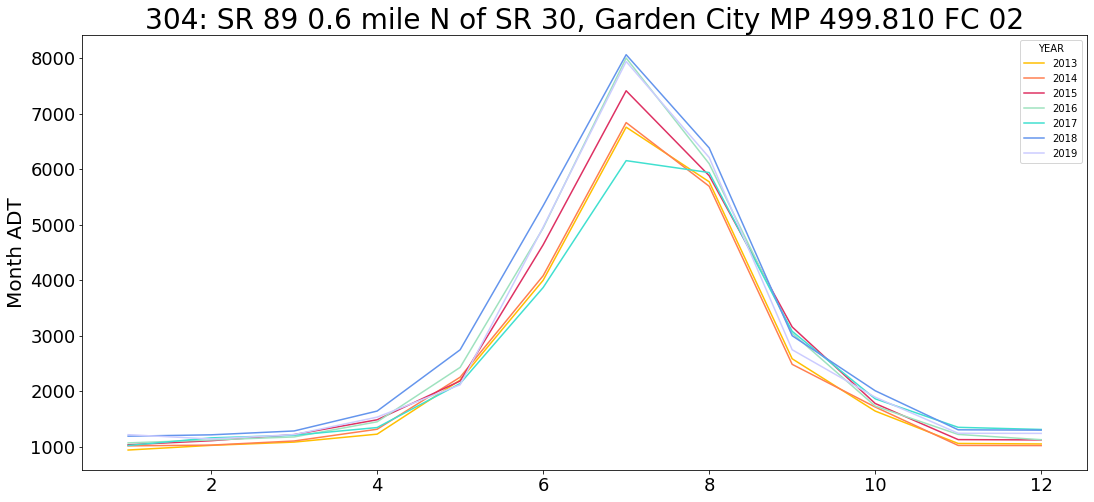

In [23]:
#Make Charts

stations = [304,305,306,307,308]

for station in stations:
    iStation = station
    dfStationData = prmStationGroups[prmStationGroups['STATIONGROUP']==str(iStation)]
    sStationName = dfStationData.iloc[0]['STATIONGROUPDESCRIPTION']

    dfPlot = df_CCSMonthADT[(df_CCSMonthADT['STATION']==iStation)]
    dfPlot = dfPlot[['YEAR','MONTH','MONTHADT']]
    dfPlot = dfPlot.pivot(index='MONTH', columns='YEAR', values='MONTHADT')
    #display(dfPlot)

    sLegend = dfPlot.columns.tolist()

    sColors = ["#FFBF00","#FF7F50","#DE3163","#9FE2BF","#40E0D0","#6495ED","#CCCCFF"]

    sBGColor = "#e8f4f8"

    aFigureSize = (18,8)
    iTitleSize = 28
    iLegendSize = 12
    iAxisItemSize = 18
    iAxisTitleSize = 20

    sXAxisLabel = ""
    sYAxisLabel = "Month ADT"

    ax = dfPlot.plot.line(figsize=aFigureSize, fontsize=iAxisItemSize, color=sColors, zorder=10)

    #set x,y labels
    ax.set_xlabel(sXAxisLabel, fontsize=iAxisTitleSize)
    ax.set_ylabel(sYAxisLabel, fontsize=iAxisTitleSize)

    sTitle = sStationName

    #set title
    ax.set_title(sTitle, fontsize=iTitleSize)
    #add title 
    #display(Markdown("# " + sTitle))

    ax.legend([sLegend1,sLegend2], prop=dict(size=iLegendSize));

    ax.grid('on', which='major', axis='y', linestyle='-', linewidth=0.5, zorder=1)

    ax.yaxis.set_major_formatter(mtick.StrMethodFormatter('{x:,.0f}'))

    ax.set_ylim([0, roundup(max(dfPlot.max(axis=1)))])

    ax.set_facecolor (sBGColor)

    # Add a table at the bottom of the axes

    #remove legend
    ax.get_legend().remove()

    # Adjust layout to make room for the table:
    plt.subplots_adjust(left=0.2, bottom=0.2)
    plt.xticks([]) #remove x tick labels

    #setup table values, use T to transpose dataframe
    df_table = dfPlot.copy()
    df_table = df_table.applymap("{:,.0f}".format)
    df_table = df_table.T
    cellValues = df_table.values.tolist()

    #columnLabels = dfPlot.T.columns
    columnLabels = ['Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sep','Oct','Nov','Dec']

    #create table and define attributes
    the_table = plt.table(cellText=cellValues,
                          rowLabels=sLegend,
                          rowColours=sColors,
                          colLabels=columnLabels,
                          rowLoc='right',
                          cellLoc='center',
                          loc='bottom')
    the_table.set_fontsize(iAxisItemSize)
    the_table.scale(1,1.8)


# Chart Daily Volume

In [ ]:
#Make Charts

stations = [304,305,306,307,308]

datefrom = '2019-01-01'
dateto   = '2019-12-31'

for station in stations:
    iStation = station
    dfStationData = prmStationGroups[(prmStationGroups['STATIONGROUP']==str(iStation))]
    sStationName = dfStationData.iloc[0]['STATIONGROUPDESCRIPTION']

    dfPlot = df_CCSDay[(df_CCSDay['STATION']==iStation) & (df_CCSDay['DATE']>=datefrom) & (df_CCSDay['DATE']<=dateto)]
    dfPlot = dfPlot[['DATE','DAYVOL','YEAR']]
    dfPlot = dfPlot.pivot(index='DATE', columns='YEAR', values='DAYVOL')
    #display(dfPlot)

    sLegend = dfPlot.columns.tolist()

    sColors = ["#FFBF00","#FF7F50","#DE3163","#9FE2BF","#40E0D0","#6495ED","#CCCCFF"]

    sBGColor = "#e8f4f8"

    aFigureSize = (18,8)
    iTitleSize = 28
    iLegendSize = 12
    iAxisItemSize = 18
    iAxisTitleSize = 20

    sXAxisLabel = ""
    sYAxisLabel = "Daily Volume"

    ax = dfPlot.plot.line(figsize=aFigureSize, fontsize=iAxisItemSize, color=sColors, zorder=10)

    #set x,y labels
    ax.set_xlabel(sXAxisLabel, fontsize=iAxisTitleSize)
    ax.set_ylabel(sYAxisLabel, fontsize=iAxisTitleSize)

    sTitle = sStationName

    #set title
    ax.set_title(sTitle, fontsize=iTitleSize)
    #add title 
    #display(Markdown("# " + sTitle))

    ax.legend([sLegend1,sLegend2], prop=dict(size=iLegendSize));

    ax.grid('on', which='major', axis='y', linestyle='-', linewidth=0.5, zorder=1)

    ax.yaxis.set_major_formatter(mtick.StrMethodFormatter('{x:,.0f}'))

    ax.set_ylim([0, roundup(max(dfPlot.max(axis=1)))])

    ax.set_facecolor (sBGColor)

    # Add a table at the bottom of the axes

    #remove legend
    ax.get_legend().remove()

    # Adjust layout to make room for the table:
    plt.subplots_adjust(left=0.2, bottom=0.2)
    #plt.xticks([]) #remove x tick labels
